In [14]:
import underworld as uw
import math
from underworld import function as fn
import glucifer
#import matplotlib.pyplot as pyplot
import time
import numpy as np
import collections

In [9]:
Xres = 128
Yres = 64
MINX = -1.
MINY = 0.
MAXX = 1.
MAXY = 1.
periodic = (True, False)

In [10]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX,MINY), 
                                 maxCoord=(MAXX,MAXY), periodic=periodic)


In [11]:
def coarse_fine_division(mesh, axis="y", refine_by=2., relax_by =0.5):
    if axis == "y":
        thisaxis = 1
    else:
        thisaxis = 0
    width = (mesh.maxCoord[thisaxis]-mesh.minCoord[thisaxis])
    dx = (mesh.maxCoord[thisaxis]-mesh.minCoord[thisaxis])/ (mesh.elementRes[thisaxis])
    nx = mesh.elementRes[thisaxis]
    dxf = dx/ refine_by
    dxc = dx/ relax_by
    print("refine By:" + str(refine_by))
    i = 0
    current_width = ((nx - i)  * dxf) + (i * dxc)
    while current_width < width:
        i += 1
        current_width = ((nx - i)  * dxf) + (i * dxc)
    #print current_width
    #correct dxc so the total domain is preserved.
    dxc = (width  - ((nx - i)  * dxf))/i
    nxf = (nx - i) 
    nxc = i
    nt = (nxf + nxc)
    assert nt == nx
    return nxf, dxf, nxc, dxc

nxf, dxf, nxc, dxc = coarse_fine_division(mesh, axis="x", refine_by=2., relax_by =0.5)

def shishkin_centre_arrange(mesh, axis="y",centre = 0.5, nxf=nxf, dxf=dxf, nxc=nxc, dxc=dxc):
    import itertools
    if axis == "y":
        thisaxis = 1
    else:
        thisaxis = 0
    print thisaxis
    ###################
    #Get the number of coarse elements either side of fine elements
    ###################
    nr = nxc
    nl = 0
    print((nxf*dxf - abs(mesh.minCoord[thisaxis])))
    if ((nxf*dxf - abs(mesh.minCoord[thisaxis])) > centre):
        print("left edge")
        pass
    else:
        left_length = (nl*dxc) + 0.5*(dxf*nxf) - abs(mesh.minCoord[thisaxis])
        while (left_length <  centre):
            nl += 1
            left_length = (nl*dxc) + 0.5*(dxf*nxf) - abs(mesh.minCoord[thisaxis])
            #print(left_length)
            if nl == nxc:
                print("right edge")
                break
        nr = nxc - nl
    print(nl, nr, nxf)
    #assert nr + nl + nxf == mesh.elementRes[thisaxis]
    ###################
    #return dictionary of new element mappings
    ###################
    lcoords = [(mesh.minCoord[thisaxis] + i*dxc) for i in range(nl+1)]
    if lcoords:
        #print(nl, lcoords[-1]/dxc)
        ccoords =  [lcoords[-1] + i*dxf for i in range(1, nxf+1)]
    else:
        ccoords =  [(mesh.minCoord[thisaxis] + i*dxf) for i in range(0, nxf)]
    rcoords = [ccoords[-1] + i*dxc for i in range(1, nr +1)]
    if rcoords:
        #rcoords.append(mesh.maxCoord[0])
        pass
    else:
        #ccoords.append(mesh.maxCoord[0])
        pass
    newcoords = lcoords+ ccoords+ rcoords
    #assert len(newcoords) == nx + 1 
    #origcoords = list(np.unique(mesh.data[:,thisaxis]))
    #origcoords = np.linspace(mesh.minCoord[thisaxis], mesh.maxCoord[thisaxis], mesh.elementRes[thisaxis])
    width = (mesh.maxCoord[thisaxis]-mesh.minCoord[thisaxis])
    dx = (mesh.maxCoord[thisaxis]-mesh.minCoord[thisaxis])/ (mesh.elementRes[thisaxis])
    origcoords = list(np.arange(mesh.minCoord[thisaxis], mesh.maxCoord[thisaxis], dx))
    origcoords.append(mesh.maxCoord[thisaxis])
    dictionary = dict(itertools.izip(origcoords, newcoords))
    assert len([x for x, y in collections.Counter(newcoords).items() if y > 1]) == 0 #checks agains multiple coordinates
    return dictionary


 
def shishkin_deform(mesh, centre = 0.5, axis="y", refine_by=2., relax_by =0.5):
    if axis == "y":
        thisaxis = 1
    else:
        thisaxis = 0
    nxf, dxf, nxc, dxc, = coarse_fine_division(mesh,axis, refine_by=refine_by, relax_by =relax_by)
    coorddict = shishkin_centre_arrange(mesh, nxf=nxf, dxf=dxf, nxc=nxc, dxc=dxc, axis=axis , centre=centre)
    with mesh.deform_mesh():
        for index, coord in enumerate(mesh.data):
            key = mesh.data[index][thisaxis]
            mesh.data[index][thisaxis] = coorddict[key]

refine By:2.0


In [15]:
shishkin_deform(mesh, centre = 0.9, axis="y", refine_by=1.5, relax_by =0.5)
shishkin_deform(mesh, centre = 0.0, axis="x", refine_by=1.5, relax_by =0.75)

refine By:1.5
1
0.5
right edge
(16, 0, 48)
refine By:1.5
0
-0.333333333333
(32, 32, 64)



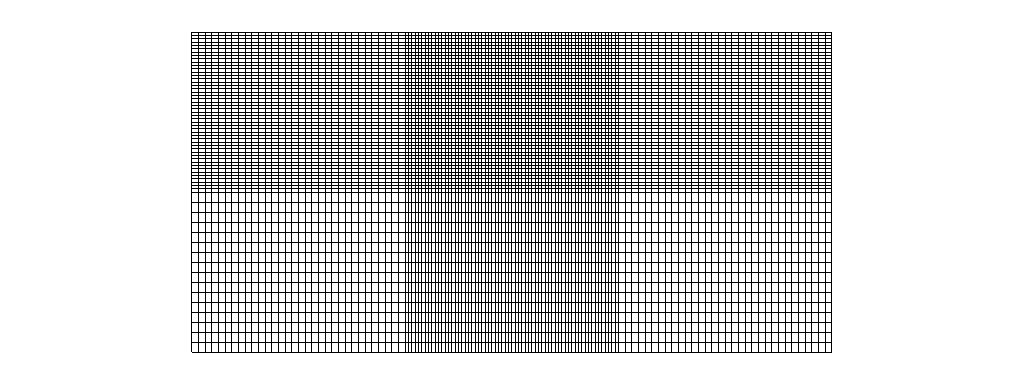

In [16]:
figSwarm = glucifer.Figure(figsize=(1024,384))
#figSwarm.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red'))
figSwarm.append( glucifer.objects.Mesh(mesh))
figSwarm.save_database('test.gldb')
figSwarm.show()